<a id=top-page></a>
# `pykitPIV` demo: Generate synthetic BOS images

In this Jupyter notebook, we show how `pykitPIV` can be used as a synthetic BOS image generator. This notebook shows the full workflow that uses the four classes in a sequence:

`Particle` $\rightarrow$ `FlowField` $\rightarrow$ `Motion` $\rightarrow$ `Image`

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#generate-particles">Generate particles</a></li>
    <li><a href="#generate-velocity-field">Generate random velocity field to advect the particles</a></li>
    <li><a href="#add-movement">Add movement to particles</a></li>
        <ul>
        <li><a href="#add-movement-update-time-sep">Update time separation</a></li>
        <li><a href="#add-movement-visualize">Visualize the PIV image pair</a></li>
        </ul>
    <li><a href="#save">Save the dataset</a></li>
    <li><a href="#upload">Upload the saved datasets</a></li>
</ol>
<p></p>
</div>
<br>

***

In [54]:
import numpy as np
import cmcrameri.cm as cmc
from scipy.ndimage import map_coordinates 
from pykitPIV import Particle, FlowField, Motion, Image

In [ ]:
save_images = False
filename = None

In [55]:
n_images = 1
image_size = (512, 512)
size_buffer = 20
origin = 'lower'
figsize = (6,6)

<a id=generate-particles></a>
***

## Generate particles

[Go to the top](#top-page)

In [56]:
particles = Particle(n_images, 
                     size=image_size, 
                     size_buffer=size_buffer,
                     diameters=10,
                     distances=1,
                     densities=1.6,
                     diameter_std=0,
                     seeding_mode='poisson',
                     random_seed=100)

In [57]:
image = Image(random_seed=100)

In [58]:
image.add_particles(particles)

In [59]:
image.add_reflected_light(exposures=0.99,
                          maximum_intensity=2**16-1,
                          no_laser_plane=True,
                          alpha=1/8,
                          extend_gaussian=2)

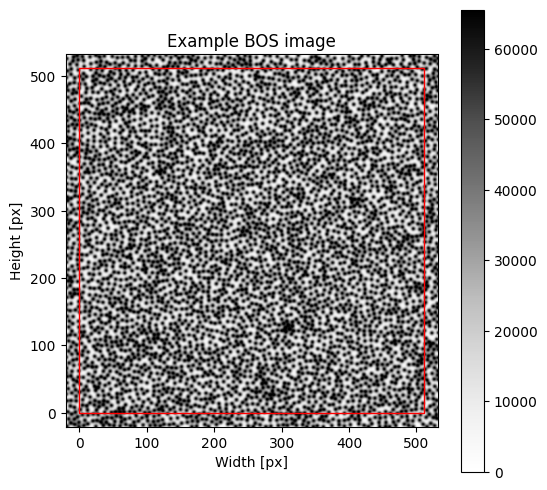

In [60]:
if save_images: filename = 'example-BOS-image-I1.png'
image.plot(0,
           instance=1,
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example BOS image',
           cmap='Greys',
           cbar=True,
           origin=origin,
           figsize=figsize,
           filename=filename);

<a id=generate-velocity-field></a>
***

## Generate potential flow field

[Go to the top](#top-page)

In [61]:
flowfield = FlowField(n_images,
                      size=image_size,
                      size_buffer=size_buffer,
                      random_seed=100)

In [62]:
flowfield.generate_potential_velocity_field(imposed_origin=None,
                                            displacement=(2, 2))

In [63]:
image.add_flowfield(flowfield)

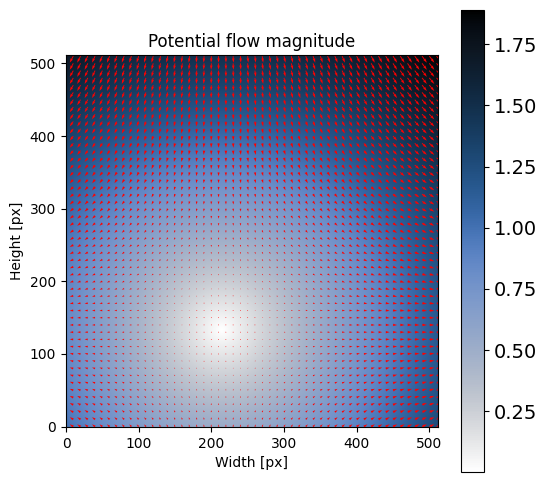

In [65]:
if save_images: filename = 'example-potential-velocity-field-magnitude-quiver.png'
image.plot_field_magnitude(0,
                           with_buffer=False,
                           add_quiver=True,
                           quiver_step=10,
                           quiver_color='r',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title='Potential flow magnitude',
                           cmap=cmc.oslo_r,
                           figsize=figsize,
                           filename=filename);

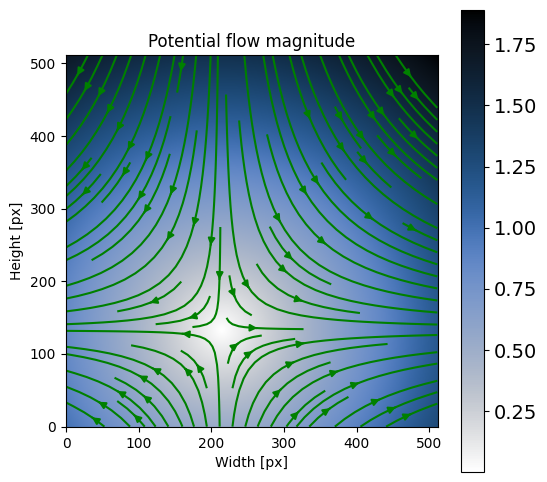

In [40]:
if save_images: filename = 'example-random-velocity-field-magnitude-streamplot.png'
image.plot_field_magnitude(0,
                           with_buffer=False,
                           add_streamplot=True,
                           streamplot_density=1,
                           streamplot_color='g',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title='Potential flow magnitude',
                           cmap=cmc.oslo_r,
                           figsize=figsize,
                           filename=filename);

<a id=add-warping></a>
***

## Add warping to BOS images

[Go to the top](#top-page)

In [41]:
time_separation = 10

In [42]:
image.warp_images(time_separation=time_separation)

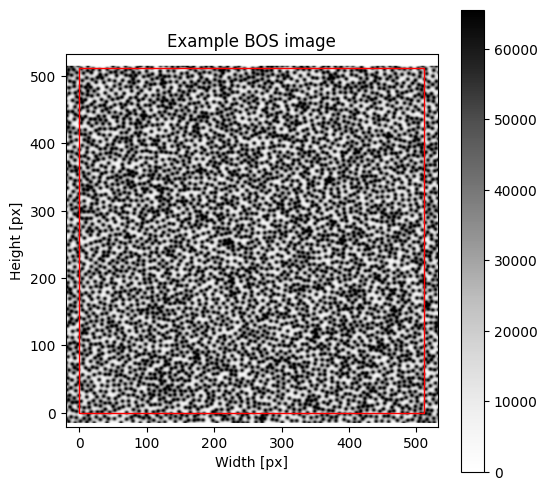

In [43]:
if save_images: filename = 'example-BOS-image-I2.png'
image.plot(0,
           instance=2,
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example BOS image',
           cmap='Greys',
           cbar=True,
           origin=origin,
           figsize=figsize,
           filename=filename);

<a id=save></a>
***

## Save the dataset

[Go to the top](#top-page)

Note, that at the last stage of the PIV image generation we may want to remove buffers from the images and the associated flow targets by running the `Image.remove_buffers()` function:

In [44]:
images_I1 = image.remove_buffers(image.images_I1)
images_I2 = image.remove_buffers(image.images_I2)

In [45]:
velocity_field = image.remove_buffers(image.get_velocity_field())
displacement_field = image.remove_buffers(image.get_velocity_field() * time_separation)

In [46]:
images_intensities = image.concatenate_tensors((images_I1, images_I2))

In [47]:
flow_targets = image.concatenate_tensors((velocity_field, displacement_field))

In [48]:
tensors_dictionary = {"I"      : images_intensities, 
                      "target" : flow_targets}

In [49]:
image.save_to_h5(tensors_dictionary, 
                 filename='pykitPIV-tutorial-BOS-pairs.h5')

<a id=upload></a>
***

## Upload the saved dataset

[Go to the top](#top-page)

The standalone import of previously saved PIV image pairs and the associated targets can be performed following this minimal example:

In [50]:
from pykitPIV import Image

In [51]:
image = Image()

In [52]:
tensors_dictionary_uploaded = image.upload_from_h5(filename='pykitPIV-tutorial-BOS-pairs.h5')

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)